In [42]:
import requests
import json
import time
import math
from datetime import datetime, timedelta

from tqdm import tqdm

"""Функция, которая записывает в vacancies полученные данные по запросу к API "Работа России"""

def getDay(modifiedFrom: datetime):

    modifiedTo = modifiedFrom + timedelta(minutes=10)
    params = {
        'modifiedFrom': f"{modifiedFrom.strftime('%Y-%m-%d')}T{modifiedFrom.hour}:{modifiedFrom.minute}:00Z",
        'modifiedTo': f"{modifiedTo.strftime('%Y-%m-%d')}T{modifiedTo.hour}:{modifiedTo.minute}:00Z",
        'limit': 100,
        'offset': 0
    }

    req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies', params)
    data = json.loads(req.content.decode())
    req.close()
    if data['results']:
        vacancies = data['results']['vacancies']
    else:
        vacancies = []
    total = int(data['meta']['total'])
    if total > 10000:
        raise Exception('total more than 10000')
    for _ in tqdm(range(math.ceil(total // 100))):
        time.sleep(0.1)
        params['offset'] += 1
        req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies', params)
        data = json.loads(req.content.decode())
        req.close()
        if data['results']:
            vacancies += data['results']['vacancies']
    return vacancies

# cобираем данные с 10 марта 2022 года (по дате раньше API не выдает данные), 
# итерируясь по 1 часу из-за ограничения на количество данных по 10000 записей за запрос

start_time = datetime(year=2022, month=8, day=21, hour=4)
end_time = datetime(year=2022, month=8, day=24)
vacancies = []

while start_time < end_time:
    try:
        vacancies += getDay(start_time)
    except Exception as e:
        print(e)
        with open('backup.json', 'w') as file:
            json.dump(vacancies, file)
            break
    start_time += timedelta(minutes=10)
    print(start_time)

100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


2022-08-21 04:10:00


100%|██████████| 24/24 [00:36<00:00,  1.52s/it]


2022-08-21 04:20:00


100%|██████████| 42/42 [01:36<00:00,  2.29s/it]


2022-08-21 04:30:00


100%|██████████| 34/34 [01:34<00:00,  2.77s/it]


2022-08-21 04:40:00


100%|██████████| 29/29 [01:17<00:00,  2.66s/it]


2022-08-21 04:50:00


100%|██████████| 22/22 [00:59<00:00,  2.70s/it]


2022-08-21 05:00:00


100%|██████████| 24/24 [01:05<00:00,  2.74s/it]


2022-08-21 05:10:00


100%|██████████| 33/33 [01:46<00:00,  3.21s/it]


2022-08-21 05:20:00


100%|██████████| 39/39 [01:59<00:00,  3.07s/it]


2022-08-21 05:30:00


100%|██████████| 38/38 [02:11<00:00,  3.46s/it]


2022-08-21 05:40:00


100%|██████████| 36/36 [01:51<00:00,  3.11s/it]


2022-08-21 05:50:00


100%|██████████| 52/52 [02:21<00:00,  2.73s/it]


2022-08-21 06:00:00


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


2022-08-21 06:10:00


0it [00:00, ?it/s]


2022-08-21 06:20:00


0it [00:00, ?it/s]


2022-08-21 06:30:00


0it [00:00, ?it/s]


2022-08-21 06:40:00


0it [00:00, ?it/s]


2022-08-21 06:50:00


0it [00:00, ?it/s]


2022-08-21 07:00:00


0it [00:00, ?it/s]


2022-08-21 07:10:00


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


2022-08-21 07:20:00


100%|██████████| 44/44 [02:02<00:00,  2.78s/it]


2022-08-21 07:30:00


100%|██████████| 37/37 [01:31<00:00,  2.48s/it]


2022-08-21 07:40:00


100%|██████████| 28/28 [01:12<00:00,  2.61s/it]


2022-08-21 07:50:00


 94%|█████████▍| 45/48 [26:01<01:44, 34.70s/it]


KeyboardInterrupt: 

In [3]:
"""Сохраняем данные в json-файл"""
with open('full_data08.json', 'w') as file:
    json.dump(vacancies, file)

KeyboardInterrupt: 

In [ ]:
"""Преобразуем json-файл в датафрейм"""
import pandas as pd
import json

with open('full_data08.json', 'r') as file:
    df = pd.json_normalize(json.load(file))

In [3]:
df["vacancy.category.specialisation"].value_counts()

Производство                                                        112474
Здравоохранение и социальное обеспечение                             61924
Образование, наука                                                   48972
Продажи, закупки, снабжение, торговля                                34398
Транспорт, автобизнес, логистика, склад, ВЭД                         24753
ЖКХ, эксплуатация                                                    20474
Строительство, ремонт, стройматериалы, недвижимость                  19229
Пищевая промышленность                                               18325
Сельское хозяйство, экология, ветеринария                            15853
Консалтинг, стратегическое развитие, управление                      15020
Работы, не требующие квалификации                                    11599
Рабочие специальности                                                 9846
Добывающая промышленность                                             8708
Информационные технологии

In [2]:
"""Выбираем нужные специализации"""

df_filtered = df[(df["vacancy.category.specialisation"] == "Информационные технологии, телекоммуникации, связь") 
| (df["vacancy.category.specialisation"] == "Искусство, культура и развлечения") | 
(df["vacancy.category.specialisation"] == "Безопасность, службы охраны") | 
(df["vacancy.category.specialisation"] == "Государственная служба, некоммерческие организации")]
df_filtered

vacancy.id    vacancy.source  \
66      b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d  Служба занятости   
115     8e6790c2-a16a-11ec-add7-bf2cfe8c828d  Служба занятости   
141     6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d  Служба занятости   
191     e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d  Служба занятости   
243     3c72e332-9fd7-11ec-add7-bf2cfe8c828d  Служба занятости   
...                                      ...               ...   
359290  12fe3323-b2fa-11ec-9aad-bf2cfe8c828d  Служба занятости   
359309  eab00b13-0042-11ec-9dd6-bf2cfe8c828d  Служба занятости   
359310  8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d  Служба занятости   
359323  8729ed62-9664-11eb-9dd6-bf2cfe8c828d  Служба занятости   
359324  193534b2-ad23-11eb-9dd6-bf2cfe8c828d  Служба занятости   

       vacancy.region.region_code    vacancy.region.name vacancy.company.ogrn  \
66                  5400000000000  Новосибирская область        1025401504039   
115                 5200000000000  Нижегородская область        1025202210538   
141                 4200000000000    Кемеровская область        1034205018110   
191                 3600000000000    Воронежская область        1023600511448   
243                 2300000000000     Краснодарский край        1022304246502   
...                           ...                    ...                  ...   
359290              1800000000000  Удмуртская Республика        1021801509828   
359309              5200000000000  Нижегородская область        1025203047385   
359310              5200000000000  Нижегородская область        1025203047385   
359323              5500000000000         Омская область        1115543001056   
359324              5500000000000         Омская область        1115543001056   

       vacancy.company.site vacancy.company.companycode  \
66        http://nokkii.ru/               1025401504039   
115                     NaN               1025202210538   
141       http://lad-dva.ru               1034205018110   
191                     NaN               1023600511448   
243                     NaN               1022304246502   
...                     ...                         ...   
359290                  NaN               1021801509828   
359309                  NaN               1025203047385   
359310                  NaN               1025203047385   
359323                  NaN               1115543001056   
359324                  NaN               1115543001056   

       vacancy.company.hr-agency vacancy.company.inn  \
66                         False          5404131424   
115                        False          5201004100   
141                        False          4206002915   
191                        False          3662180590   
243                        False          2340015390   
...                          ...                 ...   
359290                     False          1833000800   
359309                     False          5260070545   
359310                     False          5260070545   
359323                     False          5519200201   
359324                     False          5519200201   

                                     vacancy.company.name  ...  \
66      Государственное автономное профессиональное об...  ...   
115     Отдел по вопросам культуры, спорта и молодежи ...  ...   
141                               ООО  "КОМПАНИЯ ЛАД-ДВА"  ...   
191     ОВО ПО ПАНИНСКОМУ РАЙОНУ-ФИЛИАЛ ФГКУ "УВО ВНГ ...  ...   
243     ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ КРАСНОДАРС...  ...   
...                                                   ...  ...   
359290  КПОУ УР "Удмуртский республиканский колледж ку...  ...   
359309  Муниципальное бюджетное учреждение культуры "Н...  ...   
359310  Муниципальное бюджетное учреждение культуры "Н...  ...   
359323                                   БУ ЛМР "ЦКИ ЛМР"  ...   
359324                                   БУ ЛМР "ЦКИ ЛМР"  ...   

                                        vacancy.term.text vacancy.currency  \
66             

In [186]:
df_filtered["vacancy.category.specialisation"].value_counts()

Информационные технологии, телекоммуникации, связь    8624
Государственная служба, некоммерческие организации    7450
Искусство, культура и развлечения                     7440
Безопасность, службы охраны                           4928
Name: vacancy.category.specialisation, dtype: int64

In [3]:
"""Преобразуем время в формат datetime"""
from datetime import datetime

def change_date(x):
    try:
        date = datetime.strptime(x, "%Y-%m-%d")
        
    except Exception as e: # нам известно о двух ошибках в записи времени
         # если не получилось преобразовать в datetime, то исправляем эти две ошибки 
        if x == "333322-03-11":
            return datetime.strptime('2022-03-11', "%Y-%m-%d")
        return datetime.strptime('2022-03-28', "%Y-%m-%d")
        
    return date
    
df_filtered["vacancy.creation-date"] = df_filtered["vacancy.creation-date"].apply(change_date)

/Users/bobenkom/opt/anaconda3/envs/editwarsdata/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
"""Валидируем корректность даты"""

def clean_date(x):
    if x > datetime.strptime('2022-05-01', "%Y-%m-%d"):
        return None
    elif x < datetime.strptime('2016-01-01', "%Y-%m-%d"):
        return None
    return x

df_filtered["vacancy.creation-date"] = df_filtered["vacancy.creation-date"].apply(clean_date)

/Users/bobenkom/opt/anaconda3/envs/editwarsdata/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
first_date = datetime.strptime('2016-01-01', "%Y-%m-%d") 
end_date = datetime.strptime('2022-05-01', "%Y-%m-%d")
df_result = df_filtered.loc[(df_filtered["vacancy.creation-date"] < end_date) & (df_filtered["vacancy.creation-date"] > first_date)]
df_result = df_result.reset_index().drop(columns = ['index'])

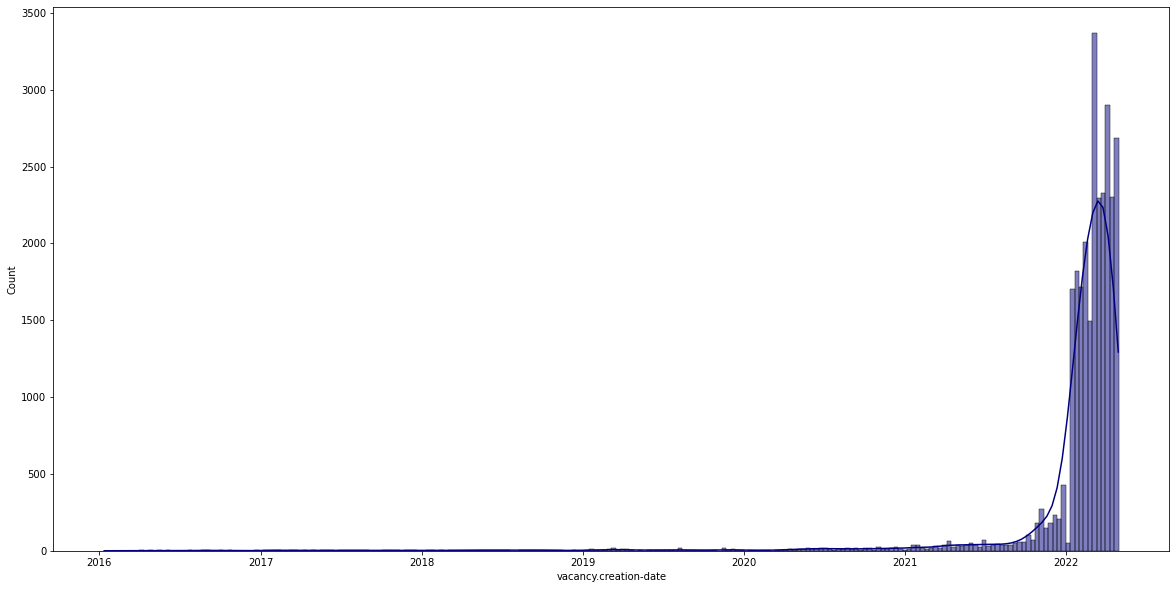

In [6]:
"""Визуализируем распредение вакансий по времени создания"""
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.histplot(data=df_result, x='vacancy.creation-date', color = 'navy', binwidth = 10, kde = True)
plt.show()

In [7]:
"""Сохраняем данные в файлы"""
df_result.to_json('result_data.json')
df_result.to_csv('result_data.csv')